In [1]:
import pandas as pd

path_to_train = '../data/train.csv'
path_to_test = '../data/test.csv'  

Основна ідея - розбити трейн на трейн та валідацію так, щоб зберегти розподіл. Ключові моменти такі:
1. В тесті є тільки користувачі, у яких є хоча б один попередній запис. Тому з теста треба видалити перший запис у всіх користувачів, щоб прибрати тих, у кого тільки один запис.
2. Також видалити старі записи перших користувачів.
3. В тесті ми маємо інший розподіл змінної `listen_type`, ніж в трейні. Буду пробувати два варіанти: тренуватися на всіх даних, або тільки на тих, де `listen_type==1`.

Треба взяти якісь фічі, котрі не сильно оверфітяться для цього датасету.

In [2]:
# видалити останній запис кожного користувача
# колонки для тренування

cols = ['genre_id', 'context_type', 'platform_name', 'platform_family', 'media_duration',
       'listen_type', 'user_gender', 'user_age']
all_cols = cols + ['user_id', 'ts_listen', 'is_listened']
train = pd.read_csv(path_to_train, encoding='utf-8', usecols=all_cols)

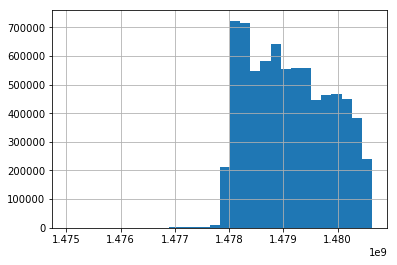

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
train[train['ts_listen'] > 1475000000]['ts_listen'].hist(bins=30)

In [4]:
train = train.sort_values(by=['user_id', 'ts_listen'], axis=0)
train.tail()

,genre_id,ts_listen,context_type,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,user_age,is_listened
2549309,0,1480199244,0,0,0,268,0,1,19913,23,1
2857394,0,1478202323,8,0,0,205,0,1,19914,18,1
4242361,1153,1477940225,1,1,0,299,1,1,19915,24,1
569368,0,1477512816,2,0,0,195,0,0,19916,25,1
4791398,25,1477926978,3,0,0,346,0,0,19917,29,1


In [5]:
by_user_count = train.groupby('user_id', as_index=False).agg({'ts_listen':'count'})
by_user_count['count'] = by_user_count['ts_listen']
del by_user_count['ts_listen']

records_for_validation = 1

users_with_one_track = by_user_count[by_user_count['count']==records_for_validation]['user_id']
users_with_one_track.head()

19666    19666
19667    19667
19668    19668
19669    19669
19670    19670
Name: user_id, dtype: int64

In [6]:
len(train)

7558834

In [7]:
train_wl = train[~train['user_id'].isin(users_with_one_track)]
len(train_wl)

7558582

In [8]:
by_user_count_wl = train_wl.groupby('user_id').agg({'ts_listen':'count'})
by_user_count_wl['ts_listen'].max()

6317

In [9]:
by_user_count_wl['ts_listen'].min()

2

Для початку спробую брати всі записи, а не тільки з флоу.

In [10]:
train_wl['index'] = train_wl.index
index_val = train_wl.groupby('user_id', as_index=False).tail(records_for_validation)['index']
len(index_val)

/home/tsdaemon/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


19666

In [11]:
index_train = train_wl.loc[~train_wl.index.isin(index_val)].groupby('user_id', as_index=False).tail(300)['index']
len(index_train)

3615600

In [12]:
train_wl = train_wl.sort_index()
del train_wl['index']
train_wl.tail()

,genre_id,ts_listen,context_type,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,user_age,is_listened
7558829,0,1480398097,23,1,0,268,1,0,2592,24,0
7558830,0,1479973465,2,0,0,974,0,0,9028,22,0
7558831,0,1479993377,4,0,2,175,1,0,393,26,0
7558832,0,1479936918,4,0,0,126,1,1,4507,29,1
7558833,0,1480029275,4,0,0,177,1,1,8129,30,1


In [13]:
test_x = train_wl.loc[index_val][cols]
test_y = train_wl.loc[index_val]["is_listened"]

train_x = train_wl.loc[index_train][cols]
train_y = train_wl.loc[index_train]["is_listened"]
len(test_x)

19666

In [14]:
import lightgbm as lgb

lgb_train = lgb.Dataset(train_x, train_y)
lgb_test = lgb.Dataset(test_x, test_y)

params = {
    'application':'binary',
    'num_leaves': 31,
    'max_depth': 20,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'max_bin': 200,
    'metric': 'auc',
    'verbose': 1
}

params = {
    'application':'binary',
    'num_leaves': 16,
    'max_depth': 10,
    'bagging_fraction': 0.7,
    'feature_fraction': 0.7,
    'max_bin': 20,
    'metric': 'auc',
    'verbose': 1
}

validation = [lgb_train,lgb_test]
model_lgm = lgb.train(params, lgb_train, 200, valid_sets=validation, verbose_eval=1)

[1]	training's auc: 0.616953	valid_1's auc: 0.493059
[2]	training's auc: 0.629735	valid_1's auc: 0.489295
[3]	training's auc: 0.628627	valid_1's auc: 0.489516
[4]	training's auc: 0.628743	valid_1's auc: 0.488015
[5]	training's auc: 0.630985	valid_1's auc: 0.48864
[6]	training's auc: 0.631758	valid_1's auc: 0.491281
[7]	training's auc: 0.631686	valid_1's auc: 0.490873
[8]	training's auc: 0.631778	valid_1's auc: 0.492048
[9]	training's auc: 0.631623	valid_1's auc: 0.492015
[10]	training's auc: 0.631697	valid_1's auc: 0.493354
[11]	training's auc: 0.631941	valid_1's auc: 0.492126
[12]	training's auc: 0.632141	valid_1's auc: 0.492999
[13]	training's auc: 0.631945	valid_1's auc: 0.490899
[14]	training's auc: 0.632459	valid_1's auc: 0.491569
[15]	training's auc: 0.632602	valid_1's auc: 0.492522
[16]	training's auc: 0.632564	valid_1's auc: 0.491858
[17]	training's auc: 0.632829	valid_1's auc: 0.492083
[18]	training's auc: 0.632852	valid_1's auc: 0.492042
[19]	training's auc: 0.633032	valid_1'

In [ ]:
importance = model_lgm.feature_importance()